# NO WINDOW FFT

In [1]:
# lets generate signal and noise samples of 5dB SNR
import numpy as np
from scipy import integrate, fftpack, signal, io, stats
import scipy.io.wavfile
from matplotlib import pyplot as plt
import matplotlib as mpl

In [2]:
# initialization for bandwidth of audio wav file
samp_rate, sig = io.wavfile.read("Casio-MT-45-16-Beat.wav")
# extract mono signal
sig = sig.mean(axis=1)
max_time = len(sig)/samp_rate
t = np.linspace(0, max_time, len(sig))

C:\Users\Lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  


In [3]:
# get the complex signal of a signal
def complex_sig(real_sig):
    return signal.hilbert(real_sig)

In [4]:
comp_sig = complex_sig(sig)

In [5]:
def add_wgnoise(sig):
    # get power of signal
    sig_pow = np.var(sig)
    # compute noise power at 5dB SNR
    snr_lin = 10**(10/10)
    noise_pow = sig_pow/snr_lin
    noise = stats.norm(0, np.sqrt(noise_pow))
    return sig + noise.rvs(*np.shape(sig))

In [6]:
sig_plus_noise = add_wgnoise(comp_sig)

In [7]:
# plot fft of sig
nfft = 1024
F_sig_plus_noise = fftpack.fft(sig_plus_noise, nfft)
f = np.linspace(0, samp_rate, nfft)

Text(0.5, 0, 'frequency')

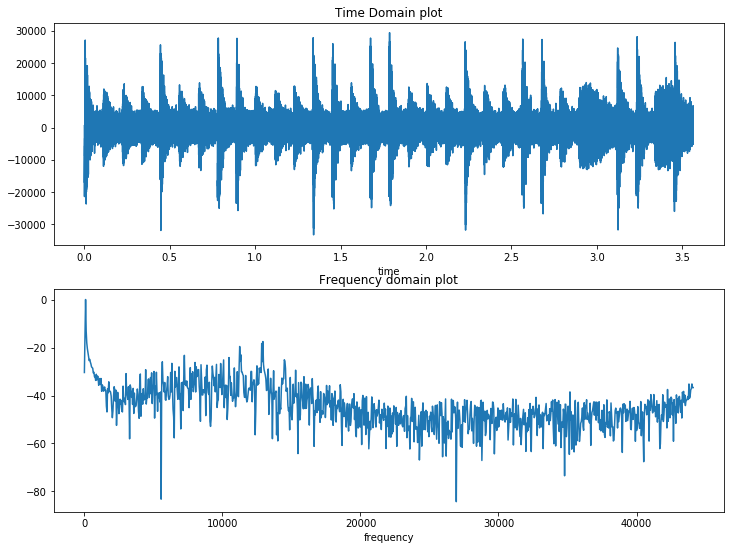

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(12,9))
ax[0].plot(t, np.real(sig_plus_noise))
ax[0].set_title("Time Domain plot")
ax[0].set_xlabel("time")

ax[1].plot(f, 20*np.log10(abs(F_sig_plus_noise)/max(abs(F_sig_plus_noise))))
ax[1].set_title("Frequency domain plot")
ax[1].set_xlabel("frequency")

# SLIDING WINDOW FFT

In [9]:
# 0.5 seconds of sample rate is 22050 samples
# we will use blackmann harris window within the signal module
# lets define a function for computing the sliding window fft
def subDomainFFT(sig, samp_rate):
    # get length of samples
    sigLen = len(sig)
    #check if sample is less than 0.5 second 
    if int(0.5*samp_rate) <= sigLen: 
        # get length of 0.5 seconds subdomain fft
        sub_samp = int(0.5*samp_rate)
        shift = int(0.5*sub_samp)
        niteration = int(sigLen//sub_samp + 1)
        # compute subdomain fft
        nfft = 1024
        window = signal.blackman(sub_samp)
        F_arr = np.zeros((niteration, nfft), dtype=complex)
        for i in range(niteration):
            subSig = sig[(i*shift):(i*shift)+sub_samp]
            if len(subSig) != sub_samp:
                # append zeros
                nzero = sub_samp - len(subSig)
                nzero_arr = np.zeros(nzero)
                subSig = np.append(subSig, nzero_arr)
            # apply window
            F_slide = fftpack.fft(subSig*window, nfft)
            # append to fft array
            F_arr[i, :] = F_slide
        return F_arr, nfft, niteration
    else:
        raise ValueError("A 0.5 second window FFT can not be computed for this signal")

In [10]:
F_slide_fft, nfft, niteration = subDomainFFT(sig_plus_noise, samp_rate)
f = np.linspace(0, samp_rate, num=nfft)

Text(0.5, 0, 'frequency')

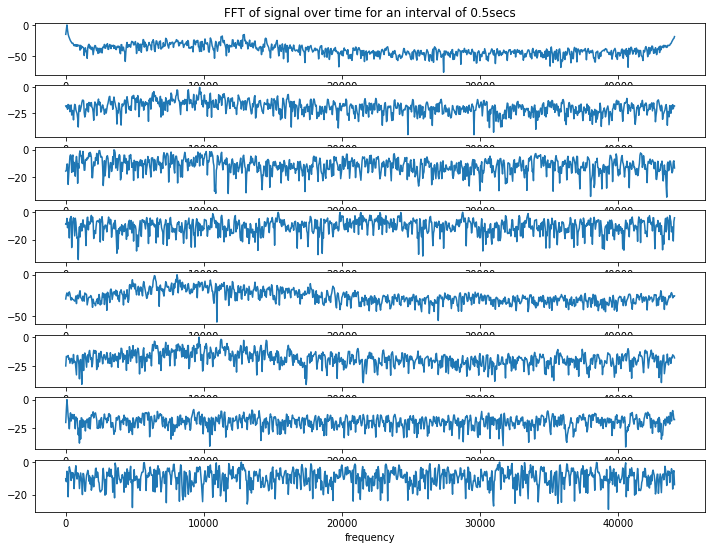

In [11]:
fig, ax = plt.subplots(niteration, 1, figsize=(12,9))
ax[0].set_title("FFT of signal over time for an interval of 0.5secs")
for i in range(niteration):
    ax[i].plot(f, 20*np.log10(abs(F_slide_fft[i])/max(abs(F_slide_fft[i]))))
ax[niteration-1].set_xlabel("frequency")

*Algorithm steps*
- Compute 1024 fft bins of 0.5 seconds of sample rate and shift by half number of samples
- Compute fixed smoothing factor of smoothing window of 0.5 seconds (Ans:0.3333)
- Find smoothed periodogram of window samples ie 1024 fft samples of sliding window
- Find the minimum of 384 samples (maintain a 3/8 ratio between range of samples to choose and the fft bin length)

In [35]:
# computing noise floor estimate on sliding window fft with fixed smoothing factor
def noise_floor_estimate1(sig, samp_rate):
    """A noise floor estimator with fixed smoothing factor"""
    # get length of samples
    sigLen = len(sig)
    #check if sample is less than 0.5 second 
    if int(0.5*samp_rate) <= sigLen: 
        # get length of 0.5 seconds subdomain fft
        sub_samp = int(0.5*samp_rate)
        shift = int(0.5*sub_samp)
        niteration = int(sigLen//sub_samp + 1)
        # compute subdomain fft
        nfft = 1024
        window = signal.blackman(sub_samp)
        pdogram_final = np.zeros((niteration, nfft))
        noise_estimate_arr = np.zeros((niteration, nfft))
        for i in range(niteration):
            subSig = sig[(i*shift):(i*shift)+sub_samp]
            if len(subSig) != sub_samp:
                # append zeros
                nzero = sub_samp - len(subSig)
                nzero_arr = np.zeros(nzero)
                subSig = np.append(subSig, nzero_arr)
            # apply window
            F_slide = fftpack.fft(subSig*window, nfft)
            # compute periodogram
            alpha = 0.3333
            if i == 0: # for the first window
                prev_pdogram = 0
            pdogram, prev_pdogram = periodogram(F_slide, prev_pdogram, alpha)
            pdogram_final[i, :] =  pdogram
        
               
            # find minimum sample in 3 of 8 samples
            win_min = 3*nfft//8
            noise_estimate = []
            for k in range(len(pdogram)): # number of iteration
                if k == 0 and i == 0: # for the first window
                    nzero = win_min - 1
                    nzero_arr = np.ones((nzero))*10*np.log10(float(pdogram[0:1]))
                    noise_range = np.append(nzero_arr, 10*np.log10(pdogram)) # noise range has length (win_len - 1) + 1024 
                elif k == 0: 
                    noise_range = np.append(noise_range, 10*np.log10(pdogram)) # append length of 1024
                # compute noise floor estimate
                min_noise = min(noise_range[(k+i*len(pdogram)):(k+i*len(pdogram))+win_min]) # shift periodogram by one sample to the right
                noise_estimate = np.append(noise_estimate, min_noise)
            noise_estimate_arr[i, :] = noise_estimate
            
        return pdogram_final, noise_estimate_arr
    else:
        raise ValueError("A 0.5 second window FFT can not be computed for this signal")
        
def periodogram(F_sig, prev_periodogram, alpha):    
    """Compute the periodogram"""
    periodogram = []
    for n in range(len(F_sig)): # for the length of sample considered
        # smoothen the sequence one sample at a time
        pres_periodogram = alpha*prev_periodogram + (1 - alpha)*abs(F_sig[n])**2
        prev_periodogram = pres_periodogram
        periodogram = np.append(periodogram, pres_periodogram)
    return periodogram, prev_periodogram 

In [36]:
periodogram, noise_floor_est = noise_floor_estimate1(sig_plus_noise, samp_rate)

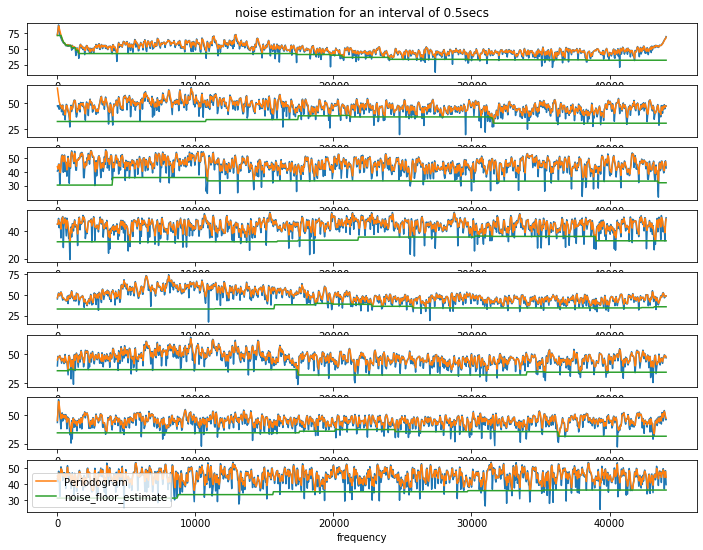

In [37]:
fig, ax = plt.subplots(niteration, 1, figsize=(12,9))
ax[0].set_title("noise estimation for an interval of 0.5secs")
for i in range(niteration):
    ax[i].plot(f, 20*np.log10(abs(F_slide_fft[i])))
    ax[i].plot(f, 10*np.log10(periodogram[i]), label="Periodogram")
    ax[i].plot(f, noise_floor_est[i], label="noise_floor_estimate")
ax[niteration-1].set_xlabel("frequency")
ax[niteration-1].legend()

# Concise minimum statistics noise estimator
*Additions to above algorithm*
- compute variable smoothening factor alpha for each 0.5 sec window
- Bound the upper limit by 0.96 to avoid dead lock
- compute normalized equivalent variance for finding the mean of the minimum statistics (optimizing noise estimator)
- compute mean normalized equivalent variance for compensation on changing noise estimation based on the variance of peridogram and by empirical means limit variance to the 0.8 - 9 dB range deviation

In [40]:
# computing noise floor estimate on sliding window fft with fixed smoothing factor
def noise_floor_estimate2(sig, samp_rate):
    """A noise floor estimator with variable smoothing factor"""
    # get length of samples
    sigLen = len(sig)
    #check if sample is less than 0.5 second 
    if int(0.5*samp_rate) <= sigLen: 
        # get length of 0.5 seconds subdomain fft
        sub_samp = int(0.5*samp_rate)
        shift = int(0.5*sub_samp)
        niteration = int(sigLen//sub_samp + 1)
        # compute subdomain fft
        nfft = 1024
        window = signal.blackman(sub_samp)
        pdogram_final = np.zeros((niteration, nfft))
        noise_estimate_arr = np.zeros((niteration, nfft))
        for i in range(niteration):
            subSig = sig[(i*shift):(i*shift)+sub_samp]
            if len(subSig) != sub_samp:
                # append zeros
                nzero = sub_samp - len(subSig)
                nzero_arr = np.zeros(nzero)
                subSig = np.append(subSig, nzero_arr)
            # apply window
            F_slide = fftpack.fft(subSig*window, nfft)
            F_slide = abs(F_slide)/max(abs(F_slide))
            # apply algorithm 
            # initialization
            if i == 0: # for the first window
                alpha_prev = last_pdogram = last_noise_est = 0
                prev_pdogram = np.ones((nfft))*float(F_slide[0:1]**2)
            else:  # set previous pdogram
                prev_pdogram = pdogram_final[i-1, :] # get last frame of periodogram
                last_noise_est = float(noise_estimate_arr[i-1, -2:-1]) # get last noise estimate
            pdogram, noise_estimate, last_pdogram, alpha_prev = \
            algorithm(F_slide, prev_pdogram, last_pdogram, last_noise_est, alpha_prev)
            pdogram_final[i, :] =  pdogram
            noise_estimate_arr[i, :] = noise_estimate
            
        return pdogram_final, noise_estimate_arr
    else:
        raise ValueError("A 0.5 second window FFT can not be computed for this signal")
        
def algorithm(F_sig, prev_periodogram, last_periodogram, min_noise, last_alpha_cor):    
    """Compute the periodogram"""
    periodogram = []
    noise_estimate = []
    alpha_max = 0.96 # upper limit on alpha_var
    # compute short term psd for each frame
    x = sum(prev_periodogram)/sum(abs(F_sig)**2) - 1
    corfac_term = 0.3*max(1/(1+x**2), 0.7)
    print("Correction factor per frame is {0}, last minimum noise sample is {1}\
    and the last correction factor is {2}".format(corfac_term, min_noise, last_alpha_cor))
    # in each frame
    for n in range(len(F_sig)):
        # compute optimum smoothening factor with previous estimated noise sample
        alpha_opt = 1/(1 + (last_periodogram/10**(min_noise/10) - 1)**2)
        alpha_cor = 0.7*last_alpha_cor + corfac_term
        alpha_var = alpha_max*alpha_cor*alpha_opt
        pres_periodogram = alpha_var*last_periodogram + (1 - alpha_var)*F_sig[n]**2
        # find minimum sample in 3 of 8 samples
        win_min = 3*len(F_sig)//8
        # append periodogram samples for a frame
        if n == 0 : #for the first sample in a frame
            noise_range = 10*np.log10(\
                            prev_periodogram[len(F_sig)-win_min+1:]) # get win_len -1 previous samples
        else:
            noise_range = np.append(noise_range, 10*np.log10(pres_periodogram))
        # slide through 3 of 8 samples
        min_noise = min(noise_range[n:n+win_min])
        last_alpha_cor = alpha_cor
        last_periodogram = pres_periodogram
        periodogram = np.append(periodogram, pres_periodogram)
        noise_estimate = np.append(noise_estimate, min_noise)
    return periodogram, noise_estimate, last_periodogram, last_alpha_cor 

In [41]:
periodogram, noise_floor_est = noise_floor_estimate2(sig_plus_noise, samp_rate)

Correction factor per frame is 0.21, last minimum noise sample is 0    and the last correction factor is 0
Correction factor per frame is 0.21, last minimum noise sample is -67.91735447524233    and the last correction factor is 0.6999999999999997
Correction factor per frame is 0.21, last minimum noise sample is -45.56188641778946    and the last correction factor is 0.6999999999999997
Correction factor per frame is 0.292072567455895, last minimum noise sample is -33.712511044391356    and the last correction factor is 0.6999999999999997
Correction factor per frame is 0.21, last minimum noise sample is -28.139502037167038    and the last correction factor is 0.973575224852983
Correction factor per frame is 0.22517230382803302, last minimum noise sample is -44.90278501607939    and the last correction factor is 0.7
Correction factor per frame is 0.21, last minimum noise sample is -39.06658283156491    and the last correction factor is 0.7505743460934431
Correction factor per frame is 0.

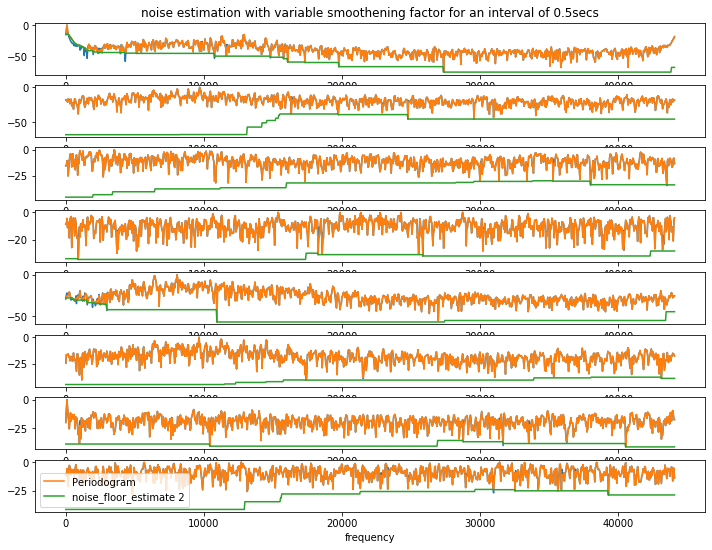

In [42]:
fig, ax = plt.subplots(niteration, 1, figsize=(12,9))
ax[0].set_title("noise estimation with variable smoothening factor for an interval of 0.5secs")
for i in range(niteration):
    ax[i].plot(f, 20*np.log10(abs(F_slide_fft[i])/max(abs(F_slide_fft[i]))))
    ax[i].plot(f, 10*np.log10(periodogram[i]), label="Periodogram")
    ax[i].plot(f, noise_floor_est[i], label="noise_floor_estimate 2")
ax[niteration-1].set_xlabel("frequency")
ax[niteration-1].legend()

## Plot of concise minimum noise estimator with variable smoothening factor

In [43]:
# computing noise floor estimate on sliding window fft with fixed smoothing factor
def noise_floor_estimate3(sig, samp_rate):
    """A noise floor estimator with variable smoothing factor"""
    # get length of samples
    sigLen = len(sig)
    #check if sample is less than 0.5 second 
    if int(0.5*samp_rate) <= sigLen: 
        # get length of 0.5 seconds subdomain fft
        sub_samp = int(0.5*samp_rate)
        shift = int(0.5*sub_samp)
        niteration = int(sigLen//sub_samp + 1)
        # compute subdomain fft
        nfft = 1024
        window = signal.blackman(sub_samp)
        pdogram_final = np.zeros((niteration, nfft))
        noise_estimate_arr = np.zeros((niteration, nfft))
        valpha_arr = np.zeros((niteration, nfft))
        for i in range(niteration):
            subSig = sig[(i*shift):(i*shift)+sub_samp]
            if len(subSig) != sub_samp:
                # append zeros
                nzero = sub_samp - len(subSig)
                nzero_arr = np.zeros(nzero)
                subSig = np.append(subSig, nzero_arr)
            # apply window
            F_slide = fftpack.fft(subSig*window, nfft)
            F_slide = abs(F_slide)/max(abs(F_slide))
            # apply algorithm 
            # initialization
            if i == 0: # for the first window
                alpha_prev = last_pdogram = last_noise_est = 0
                prev_pdogram = np.ones((nfft))*float(F_slide[0:1]**2)
            else:  # set previous pdogram
                prev_pdogram = pdogram_final[i-1, :] # get last frame of periodogram
                last_noise_est = float(noise_estimate_arr[i-1, -2:-1]) # get last noise estimate
            pdogram, noise_estimate, last_pdogram, alpha_prev, valpha = \
            algorithm(F_slide, prev_pdogram, last_pdogram, last_noise_est, alpha_prev)
            pdogram_final[i, :] =  pdogram
            noise_estimate_arr[i, :] = noise_estimate
            valpha_arr[i, :] = valpha
            
        return pdogram_final, valpha_arr, noise_estimate_arr
    else:
        raise ValueError("A 0.5 second window FFT can not be computed for this signal")
        
def algorithm(F_sig, prev_periodogram, last_periodogram, min_noise, last_alpha_cor):    
    """Compute the periodogram"""
    periodogram = []
    noise_estimate = []
    valpha = []
    alpha_max = 0.96 # upper limit on alpha_var
    # compute short term psd for each frame
    x = sum(prev_periodogram)/sum(abs(F_sig)**2) - 1
    corfac_term = 0.3*max(1/(1+x**2), 0.7)
    # in each frame
    for n in range(len(F_sig)):
        # compute optimum smoothening factor with previous estimated noise sample
        alpha_opt = 1/(1 + (last_periodogram/10**(min_noise/10) - 1)**2)
        alpha_cor = 0.7*last_alpha_cor + corfac_term
        alpha_var = alpha_max*alpha_cor*alpha_opt
        pres_periodogram = alpha_var*last_periodogram + (1 - alpha_var)*F_sig[n]**2
        # find minimum sample in 3 of 8 samples
        win_min = 3*len(F_sig)//8
        # append periodogram samples for a frame
        if n == 0 : #for the first sample in a frame
            noise_range = 10*np.log10(\
                            prev_periodogram[len(F_sig)-win_min+1:]) # get win_len -1 previous samples
        else:
            noise_range = np.append(noise_range, 10*np.log10(pres_periodogram))
        # slide through 3 of 8 samples
        min_noise = min(noise_range[n:n+win_min])
        last_alpha_cor = alpha_cor
        last_periodogram = pres_periodogram
        periodogram = np.append(periodogram, pres_periodogram)
        noise_estimate = np.append(noise_estimate, min_noise)
        valpha = np.append(valpha, alpha_var)
    return periodogram, noise_estimate, last_periodogram, last_alpha_cor, valpha 

In [44]:
periodogram, valpha, noise_floor_est = noise_floor_estimate3(sig_plus_noise, samp_rate)

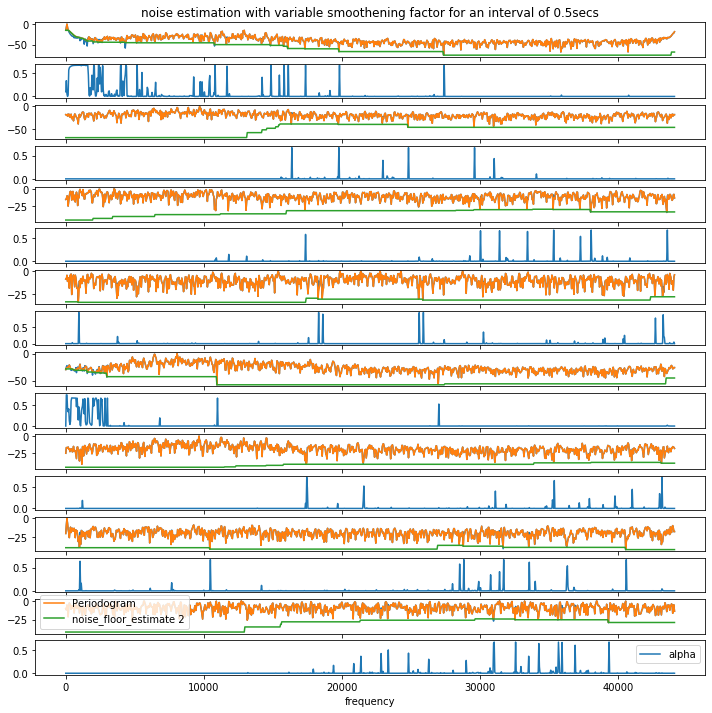

In [45]:
fig, ax = plt.subplots(niteration*2, 1, figsize=(12,12))
ax[0].set_title("noise estimation with variable smoothening factor for an interval of 0.5secs")
for i in range(niteration):
    ax[2*i].plot(f, 20*np.log10(abs(F_slide_fft[i])/max(abs(F_slide_fft[i]))))
    ax[2*i].plot(f, 10*np.log10(periodogram[i]/max(periodogram[i])), label="Periodogram")
    ax[2*i].plot(f, noise_floor_est[i], label="noise_floor_estimate 2")
    ax[2*i + 1].plot(f, valpha[i], label="alpha")
ax[niteration*2-1].set_xlabel("frequency")
ax[niteration*2-1].legend()
ax[niteration*2-2].legend()

## optimizing minimum noise stats

- introduce the bais factor as well as the correction factor

In [182]:
# computing noise floor estimate on sliding window fft with fixed smoothing factor
def noise_floor_estimate4(sig, samp_rate):
    """A noise floor estimator with variable smoothing factor"""
    # get length of samples
    sigLen = len(sig)
    #check if sample is less than 0.5 second 
    if int(0.5*samp_rate) <= sigLen: 
        # get length of 0.5 seconds subdomain fft
        sub_samp = int(0.5*samp_rate)
        shift = int(0.5*sub_samp)
        niteration = int(sigLen//sub_samp + 1)
        # compute subdomain fft
        nfft = 1024
        window = signal.blackman(sub_samp)
        pdogram_final = np.zeros((niteration, nfft))
        noise_estimate_arr = np.zeros((niteration, nfft))
        valpha_arr = np.zeros((niteration, nfft))
        eq_deg_arr = np.zeros((niteration, nfft))
        for i in range(niteration):
            subSig = sig[(i*shift):(i*shift)+sub_samp]
            if len(subSig) != sub_samp:
                # append zeros
                nzero = sub_samp - len(subSig)
                nzero_arr = np.zeros(nzero)
                subSig = np.append(subSig, nzero_arr)
            # apply window
            F_slide = fftpack.fft(subSig*window, nfft)
            F_slide = abs(F_slide)/max(abs(F_slide))
            # apply algorithm 
            # initialization
            if i == 0: # for the first window
                alpha_prev = last_pdogram = last_noise_est = avg_norm = 0
                last_mean_pdogram = last_mean_sqr_pdogram = 0
                prev_pdogram = np.ones((nfft))*float(F_slide[0:1]**2)
            else:  # set previous pdogram
                prev_pdogram = pdogram_final[i-1, :] # get last frame of periodogram
                last_noise_est = float(noise_estimate_arr[i-1, -2:-1]) # get last noise estimate
                # compute average normalized variance
                avg_norm = sum(eq_deg_arr[i-1, :])/len(eq_deg_arr[i-1, :])
                
            pdogram, noise_estimate, last_pdogram, alpha_prev, valpha,\
            last_mean_pdogram, last_mean_sqr_pdogram, eq_deg_per_frame = \
            algorithm(F_slide, prev_pdogram, last_pdogram, last_noise_est, alpha_prev,\
                      last_mean_pdogram, last_mean_sqr_pdogram, avg_norm)
            pdogram_final[i, :] =  pdogram
            noise_estimate_arr[i, :] = noise_estimate
            valpha_arr[i, :] = valpha
            eq_deg_arr[i, :] = eq_deg_per_frame
            
        return pdogram_final, valpha_arr, noise_estimate_arr
    else:
        raise ValueError("A 0.5 second window FFT can not be computed for this signal")
        
def algorithm(F_sig, prev_periodogram, last_periodogram, min_noise, last_alpha_cor,\
              prev_fmoment, prev_smoment, avg_norm):    
    """Compute the periodogram"""
    periodogram = []
    noise_estimate = []
    valpha = []
    eq_deg_per_frame = []
    alpha_max = 0.96 # upper limit on alpha_var
    print("Average normalized variance is", avg_norm)
    # compute short term psd for each frame
    x = sum(prev_periodogram)/sum(abs(F_sig)**2) - 1
    corfac_term = 0.3*max(1/(1+x**2), 0.7)
    # in each frame
    for n in range(len(F_sig)):
        # compute optimum smoothening factor with previous estimated noise sample
        alpha_opt = 1/(1 + (last_periodogram/10**(min_noise/10) - 1)**2)
        alpha_cor = 0.7*last_alpha_cor + corfac_term
        alpha_var = alpha_max*alpha_cor*alpha_opt
        beta_var = min(alpha_var**2, 0.8)
#         print("variable smootheneing factor beta is ", beta_var)
        pres_periodogram = alpha_var*last_periodogram + (1 - alpha_var)*F_sig[n]**2
        # compute firt moment of periodogrm
        fmoment = beta_var*prev_fmoment + (1 - beta_var)*pres_periodogram
        # compute second moment of periodogram
        smoment = beta_var*prev_smoment + (1 - beta_var)*pres_periodogram**2
        # estimated variance
        est_var = abs(smoment - fmoment)
#         print("Estimated variance is", est_var)
        # equivalent degree of freedom
        eq_deg = 20*np.log10(0.5*est_var)-min_noise
        eq_deg = 10**(eq_deg/10)
#         print("Equivalent degree of freedom",1/eq_deg)
        # find minimum sample in 3 of 8 samples
        win_min = 3*len(F_sig)//8
        # computing inverse bias
        eq_deg_tilda = abs((1/eq_deg - 2/3)/(1 - 1/3))
#         print("The simplified equivalent degree of freedom is", eq_deg_tilda)
        bias = (win_min - 1)*2/eq_deg_tilda
        bias = 1 + bias
        # append periodogram samples for a frame
        if n == 0 : #for the first sample in a frame
            noise_range = 10*np.log10(\
                            bias*prev_periodogram[len(F_sig)-win_min+1:]) # get win_len -1 previous samples
        else:
            noise_range = np.append(noise_range, 10*np.log10(bias*pres_periodogram))
        
        print("The Bias or inverse mean is", bias)
#         db constraints between 0.8-9dB
        if avg_norm < 0.03:
            noise_slope_max = 9
        elif avg_norm < 0.05:
            noise_slope_max = 6
        elif avg_norm < 0.06:
            noise_slope_max = 3
        else:
            noise_slope_max = 0.8
        # slide through 3 of 8 samples
        min_stats = min(noise_range[n:n+win_min])
        min_noise = min_stats+noise_slope_max
#         print("min noise is", min_noise)
        last_alpha_cor = alpha_cor
        last_periodogram = pres_periodogram
        last_mean_pdogram = fmoment
        last_mean_sqr_pdogram = smoment
        periodogram = np.append(periodogram, pres_periodogram)
        noise_estimate = np.append(noise_estimate, min_noise)
        valpha = np.append(valpha, alpha_var)
        eq_deg_per_frame = np.append(eq_deg_per_frame, eq_deg)
    return periodogram, noise_estimate, last_periodogram, last_alpha_cor, valpha,\
           last_mean_pdogram, last_mean_sqr_pdogram, eq_deg_per_frame

In [183]:
periodogram, valpha, noise_floor_est = noise_floor_estimate4(sig_plus_noise, samp_rate)

Average normalized variance is 0
The Bias or inverse mean is 1.092801316987613
The Bias or inverse mean is 7.070084909841217
The Bias or inverse mean is 17.62620408317213
The Bias or inverse mean is 15.41354414011615
The Bias or inverse mean is 4.412306096621919
The Bias or inverse mean is 2.356672457844925
The Bias or inverse mean is 1.3842657161860203
The Bias or inverse mean is 1.0861110422980589
The Bias or inverse mean is 1.0397353838431216
The Bias or inverse mean is 1.0254259902121248
The Bias or inverse mean is 1.0160325377592092
The Bias or inverse mean is 1.012282024576852
The Bias or inverse mean is 1.0134943473456244
The Bias or inverse mean is 1.0080080122997552
The Bias or inverse mean is 1.0052024314392718
The Bias or inverse mean is 1.0073880350069788
The Bias or inverse mean is 1.0048645473356694
The Bias or inverse mean is 1.0092581441640949
The Bias or inverse mean is 1.0051991317141236
The Bias or inverse mean is 1.0090723133702078
The Bias or inverse mean is 1.0055

The Bias or inverse mean is 1.0609035975296017
The Bias or inverse mean is 5.493127025875903
The Bias or inverse mean is 1.095688883900623
The Bias or inverse mean is 1.081516900729754
The Bias or inverse mean is 1.0680790301389127
The Bias or inverse mean is 1.2335154900259964
The Bias or inverse mean is 1.650446480848255
The Bias or inverse mean is 1.0339884681126341
The Bias or inverse mean is 1.0168033221534678
The Bias or inverse mean is 1.1566187740734366
The Bias or inverse mean is 4.342283889276003
The Bias or inverse mean is 1.0974099450699693
The Bias or inverse mean is 1.0263762546748187
The Bias or inverse mean is 1.0106838157794722
The Bias or inverse mean is 1.0066268611924487
The Bias or inverse mean is 1.0048713513939977
The Bias or inverse mean is 1.0036144940544451
The Bias or inverse mean is 1.0081618887441228
The Bias or inverse mean is 1.0081439924835958
The Bias or inverse mean is 1.0110044286096869
The Bias or inverse mean is 1.0075217741295592
The Bias or invers

The Bias or inverse mean is 1.0056818421330231
The Bias or inverse mean is 1.0034814266688077
The Bias or inverse mean is 1.0015497369356263
The Bias or inverse mean is 1.0037908005032552
The Bias or inverse mean is 1.008655325024434
The Bias or inverse mean is 1.0134906735237206
The Bias or inverse mean is 1.0318070219874074
The Bias or inverse mean is 1.1285161095944618
The Bias or inverse mean is 1.2191213886288452
The Bias or inverse mean is 1.027622966162123
The Bias or inverse mean is 1.0040866673262567
The Bias or inverse mean is 1.0013036529970294
The Bias or inverse mean is 1.0009918806971454
The Bias or inverse mean is 1.0005853564092095
The Bias or inverse mean is 1.0002948861588359
The Bias or inverse mean is 1.0008494941728163
The Bias or inverse mean is 1.0002970772112298
The Bias or inverse mean is 1.002394380132478
The Bias or inverse mean is 1.0010038497117963
The Bias or inverse mean is 1.0018112105510144
The Bias or inverse mean is 1.002562594582161
The Bias or inver

The Bias or inverse mean is 1.0000608316198707
The Bias or inverse mean is 1.0012944330523452
The Bias or inverse mean is 1.001495895596171
The Bias or inverse mean is 1.0005258926416551
The Bias or inverse mean is 1.0002563067615808
The Bias or inverse mean is 1.0023599173145503
The Bias or inverse mean is 1.000796527765416
The Bias or inverse mean is 1.0006524554995377
The Bias or inverse mean is 1.0010064889936945
The Bias or inverse mean is 1.0128474335433757
The Bias or inverse mean is 1.0445022567940225
The Bias or inverse mean is 1.0430984270221386
The Bias or inverse mean is 1.0036069850076952
The Bias or inverse mean is 1.0008372866672464
The Bias or inverse mean is 1.0003794724184263
The Bias or inverse mean is 1.0024260426224643
The Bias or inverse mean is 1.000921317321154
The Bias or inverse mean is 1.0004852676675722
The Bias or inverse mean is 1.0002483944576082
The Bias or inverse mean is 1.0097281901091038
The Bias or inverse mean is 1.042355971171057
The Bias or inver

The Bias or inverse mean is 4.079264647962933
The Bias or inverse mean is 4.557402654533704
The Bias or inverse mean is 9.902437471418194
The Bias or inverse mean is 2.2177230039202422
The Bias or inverse mean is 3.433383137504965
The Bias or inverse mean is 3.531240453819864
The Bias or inverse mean is 6.1157557684648065
The Bias or inverse mean is 6.319444839155818
The Bias or inverse mean is 8.984306508385195
The Bias or inverse mean is 10.428116276009423
The Bias or inverse mean is 5.3419946880119
The Bias or inverse mean is 2.090920731788758
The Bias or inverse mean is 6.076434306818495
The Bias or inverse mean is 17.56482186673515
The Bias or inverse mean is 70.85864116630896
The Bias or inverse mean is 1.919805561532114
The Bias or inverse mean is 6.065207931569057
The Bias or inverse mean is 96.16270011554167
The Bias or inverse mean is 1120.3743321363474
The Bias or inverse mean is 22.749356175895834
The Bias or inverse mean is 2236.7556743109417
The Bias or inverse mean is 16

The Bias or inverse mean is 5.284045968186739
The Bias or inverse mean is 3.357752110844479
The Bias or inverse mean is 2.566331341704387
The Bias or inverse mean is 2.2853081732161775
The Bias or inverse mean is 1.9582186850840229
The Bias or inverse mean is 2.682158897034514
The Bias or inverse mean is 3.9078751720036884
The Bias or inverse mean is 4.881076586133021
The Bias or inverse mean is 6.037670531237082
The Bias or inverse mean is 6.239826697713817
The Bias or inverse mean is 5.425219635406171
The Bias or inverse mean is 20.23113868979176
The Bias or inverse mean is 2.106535646206944
The Bias or inverse mean is 3.3686358693352014
The Bias or inverse mean is 2.934057516713584
The Bias or inverse mean is 3.2061138120061115
The Bias or inverse mean is 2.8079113832689844
The Bias or inverse mean is 3.4775993298519574
The Bias or inverse mean is 13.310813298815367
The Bias or inverse mean is 6.8354311225980116
The Bias or inverse mean is 2.988526198692139
The Bias or inverse mean 

The Bias or inverse mean is 2.8552771317117163
The Bias or inverse mean is 2.3139982352067188
The Bias or inverse mean is 1.907924599320261
The Bias or inverse mean is 1.6795546010428868
The Bias or inverse mean is 1.6555383604642726
The Bias or inverse mean is 1.684765633780188
The Bias or inverse mean is 1.6603146578469792
The Bias or inverse mean is 2.020304982132346
The Bias or inverse mean is 2.540739660062263
The Bias or inverse mean is 2.6409695229717447
The Bias or inverse mean is 2.709719142754865
The Bias or inverse mean is 2.1326352479965442
The Bias or inverse mean is 2.2135870690197956
The Bias or inverse mean is 2.1704021476522453
The Bias or inverse mean is 2.0866582378826646
The Bias or inverse mean is 1.984430350375877
The Bias or inverse mean is 2.4695166154856985
The Bias or inverse mean is 2.1334650539373534
The Bias or inverse mean is 2.9269200108358904
The Bias or inverse mean is 5.847125929773351
The Bias or inverse mean is 19.0045744483345
The Bias or inverse me

The Bias or inverse mean is 4.178559429238987
The Bias or inverse mean is 2.308164803629621
The Bias or inverse mean is 6.201971660458852
The Bias or inverse mean is 78.6328128989046
The Bias or inverse mean is 28.974861818480164
The Bias or inverse mean is 7.664995550393567
The Bias or inverse mean is 50.58605705055705
The Bias or inverse mean is 20.299532136753648
The Bias or inverse mean is 5.626615323015494
The Bias or inverse mean is 88.13551170099474
The Bias or inverse mean is 93.63718813353911
The Bias or inverse mean is 8.967899250490998
The Bias or inverse mean is 3.3774708225885894
The Bias or inverse mean is 15.338723974801646
The Bias or inverse mean is 1.6669320763188855
The Bias or inverse mean is 4.409202538967499
The Bias or inverse mean is 11.842288029316173
The Bias or inverse mean is 23.148939791257057
The Bias or inverse mean is 2.349357891077813
The Bias or inverse mean is 5.719492505515537
The Bias or inverse mean is 1.4200474092720365
The Bias or inverse mean is

The Bias or inverse mean is 4.558901847938358
The Bias or inverse mean is 25.086366382560545
The Bias or inverse mean is 4.255946574107078
The Bias or inverse mean is 3.302734958950853
The Bias or inverse mean is 1.404359121274351
The Bias or inverse mean is 2.5190986890640206
The Bias or inverse mean is 2.7552858476724955
The Bias or inverse mean is 9.356501042336738
The Bias or inverse mean is 106.79527457937812
The Bias or inverse mean is 145.74392966639704
The Bias or inverse mean is 35.431245223121266
The Bias or inverse mean is 9.740114353523674
The Bias or inverse mean is 3.6855516036324247
The Bias or inverse mean is 2.4869664939245375
The Bias or inverse mean is 7.010496822247497
The Bias or inverse mean is 6.309705374195538
The Bias or inverse mean is 1.153544447068647
The Bias or inverse mean is 2.11510392434484
The Bias or inverse mean is 2.360306065023791
The Bias or inverse mean is 2.9057536491192604
The Bias or inverse mean is 3.541655841456619
The Bias or inverse mean i

The Bias or inverse mean is 14.308177338658052
The Bias or inverse mean is 32.05566302111259
The Bias or inverse mean is 49.174209088462405
The Bias or inverse mean is 13.117954132142895
The Bias or inverse mean is 5.444448767628132
The Bias or inverse mean is 3.1603335120400784
The Bias or inverse mean is 11.179482734325733
The Bias or inverse mean is 59.865457576407024
The Bias or inverse mean is 92.4511868859565
The Bias or inverse mean is 27.815059693578217
The Bias or inverse mean is 6.594821509388619
The Bias or inverse mean is 8.6599105883498
The Bias or inverse mean is 26.342010098539824
The Bias or inverse mean is 9.767524290659237
The Bias or inverse mean is 4.235455293262478
The Bias or inverse mean is 5.051526700469443
The Bias or inverse mean is 12.360713913007627
The Bias or inverse mean is 84.35871833199604
The Bias or inverse mean is 31.586764474683843
The Bias or inverse mean is 15.943978923433288
The Bias or inverse mean is 16.15444656681786
The Bias or inverse mean i

The Bias or inverse mean is 3.797275871739833
The Bias or inverse mean is 7.334057210205081
The Bias or inverse mean is 13.168512521611701
The Bias or inverse mean is 7.569289828590937
The Bias or inverse mean is 3.4303664269062275
The Bias or inverse mean is 4.035543928415009
The Bias or inverse mean is 3.7202514625075667
The Bias or inverse mean is 3.041415336176665
The Bias or inverse mean is 2.2676529431898413
The Bias or inverse mean is 5.545915319282425
The Bias or inverse mean is 9.05201195646381
The Bias or inverse mean is 8.202369361077107
The Bias or inverse mean is 4.295755025391653
The Bias or inverse mean is 5.269611917420699
The Bias or inverse mean is 5.505741740548482
The Bias or inverse mean is 4.531699580110009
The Bias or inverse mean is 4.249137098315336
The Bias or inverse mean is 5.726674667242336
The Bias or inverse mean is 5.163310425229517
The Bias or inverse mean is 4.031828409679267
The Bias or inverse mean is 3.087272208848593
The Bias or inverse mean is 3.1

The Bias or inverse mean is 7.5382011724199245
The Bias or inverse mean is 4.490799393465686
The Bias or inverse mean is 2.904130596893803
The Bias or inverse mean is 2.390481746763225
The Bias or inverse mean is 3.157228651766113
The Bias or inverse mean is 2.3954563502651016
The Bias or inverse mean is 1.5860236660995146
The Bias or inverse mean is 1.1898402258487506
The Bias or inverse mean is 1.1835662607210662
The Bias or inverse mean is 1.4512547533544233
The Bias or inverse mean is 9.703949259825501
The Bias or inverse mean is 42.443027828193195
The Bias or inverse mean is 27.56968864708902
The Bias or inverse mean is 29.621032294440642
The Bias or inverse mean is 2.6873370183602523
The Bias or inverse mean is 2.2740535660892114
The Bias or inverse mean is 2.455261599855187
The Bias or inverse mean is 16.774365680627064
The Bias or inverse mean is 118.95501161027516
The Bias or inverse mean is 19.224119257452504
The Bias or inverse mean is 41.23889372924079
The Bias or inverse m

The Bias or inverse mean is 103.08984737390702
The Bias or inverse mean is 261.2415096680005
The Bias or inverse mean is 54.21022704315201
The Bias or inverse mean is 4.872505319192283
The Bias or inverse mean is 3.43716141250344
The Bias or inverse mean is 2.592073301773862
The Bias or inverse mean is 11.707954453282214
The Bias or inverse mean is 172.31885110834483
The Bias or inverse mean is 334.28593348933106
The Bias or inverse mean is 328.8225231581777
The Bias or inverse mean is 176.7515576699709
The Bias or inverse mean is 230.4151280520115
The Bias or inverse mean is 147.8263908370948
The Bias or inverse mean is 280.71591939311634
The Bias or inverse mean is 264.45092152907927
The Bias or inverse mean is 243.30337856891106
The Bias or inverse mean is 293.4600101432257
The Bias or inverse mean is 321.27673807119294
The Bias or inverse mean is 10.421014182433096
The Bias or inverse mean is 11.842939520910859
The Bias or inverse mean is 51.16294908070992
The Bias or inverse mean 

The Bias or inverse mean is 9.106997200700917
The Bias or inverse mean is 28.57321511071985
The Bias or inverse mean is 3.842369983624392
The Bias or inverse mean is 2.2128968626149437
The Bias or inverse mean is 2.1192775892264564
The Bias or inverse mean is 5.392266772368635
The Bias or inverse mean is 3.4935237989825363
The Bias or inverse mean is 3.1283779408366224
The Bias or inverse mean is 2.3104903144978723
The Bias or inverse mean is 1.692120288419434
The Bias or inverse mean is 7.443417330791462
The Bias or inverse mean is 13.275377795897782
The Bias or inverse mean is 6.650148754606797
The Bias or inverse mean is 4.013862615405452
The Bias or inverse mean is 8.735103194801322
The Bias or inverse mean is 38.75940993865837
The Bias or inverse mean is 24.701334101515105
The Bias or inverse mean is 8.023548066153412
The Bias or inverse mean is 3.8746875201515936
The Bias or inverse mean is 3.2818283246937803
The Bias or inverse mean is 7.027111630550114
The Bias or inverse mean 

The Bias or inverse mean is 4.450095187775158
The Bias or inverse mean is 4.551234679828002
The Bias or inverse mean is 4.3429798675101186
The Bias or inverse mean is 4.420005588409671
The Bias or inverse mean is 4.269974889791236
The Bias or inverse mean is 6.252915148337736
The Bias or inverse mean is 4.783682978050317
The Bias or inverse mean is 4.874847237221856
The Bias or inverse mean is 5.014979618240271
The Bias or inverse mean is 4.915249746062107
The Bias or inverse mean is 4.643647338707497
The Bias or inverse mean is 4.489113333275993
The Bias or inverse mean is 4.489076618668157
The Bias or inverse mean is 4.441223082602354
The Bias or inverse mean is 4.394216705660107
The Bias or inverse mean is 4.534595894178942
The Bias or inverse mean is 5.507018784088945
The Bias or inverse mean is 4.599505361309495
The Bias or inverse mean is 4.788341033915874
The Bias or inverse mean is 5.694603980730927
The Bias or inverse mean is 11.921493732926248
The Bias or inverse mean is 30.0

The Bias or inverse mean is 12.66857316916341
The Bias or inverse mean is 10.284089902522526
The Bias or inverse mean is 7.436739401342336
The Bias or inverse mean is 20.117653004167927
The Bias or inverse mean is 20.69716901703444
The Bias or inverse mean is 13.01125800001731
The Bias or inverse mean is 15.282654264740692
The Bias or inverse mean is 22.601737979336733
The Bias or inverse mean is 10.35893156169592
The Bias or inverse mean is 6.340032517216029
The Bias or inverse mean is 8.23668989721332
The Bias or inverse mean is 11.945759438631361
The Bias or inverse mean is 45.48018542789716
The Bias or inverse mean is 79.92578180762797
The Bias or inverse mean is 9.382763793738336
The Bias or inverse mean is 6.567996427724793
The Bias or inverse mean is 9.41546128178677
The Bias or inverse mean is 14.668796992636468
The Bias or inverse mean is 38.070615426656765
The Bias or inverse mean is 44.57026191050068
The Bias or inverse mean is 33.79290078265566
The Bias or inverse mean is 3

The Bias or inverse mean is 4.902767353619582
The Bias or inverse mean is 5.326679930339305
The Bias or inverse mean is 4.528051146460626
The Bias or inverse mean is 4.151903620089604
The Bias or inverse mean is 4.1574171900321835
The Bias or inverse mean is 4.226147684026868
The Bias or inverse mean is 3.618844617517032
The Bias or inverse mean is 3.48243418871927
The Bias or inverse mean is 5.744464657370622
The Bias or inverse mean is 5.258051566056362
The Bias or inverse mean is 4.867203689292619
The Bias or inverse mean is 5.2837039948686915
The Bias or inverse mean is 5.061415857825793
The Bias or inverse mean is 5.069182005525544
The Bias or inverse mean is 4.851514418269067
The Bias or inverse mean is 4.976589381509347
The Bias or inverse mean is 4.774727358902548
The Bias or inverse mean is 4.618370032051526
The Bias or inverse mean is 4.419976637121408
The Bias or inverse mean is 5.318508130921204
The Bias or inverse mean is 5.800540464956496
The Bias or inverse mean is 5.199

The Bias or inverse mean is 3.875037289207676
The Bias or inverse mean is 3.0992864459631426
The Bias or inverse mean is 2.5348169505889473
The Bias or inverse mean is 3.8445802893735497
The Bias or inverse mean is 7.763788374259707
The Bias or inverse mean is 5.082143922257915
The Bias or inverse mean is 5.201676950052979
The Bias or inverse mean is 5.231859753552609
The Bias or inverse mean is 5.112330269564046
The Bias or inverse mean is 4.974176022305581
The Bias or inverse mean is 4.782668238410077
The Bias or inverse mean is 5.471709609653707
The Bias or inverse mean is 5.576624738624784
The Bias or inverse mean is 5.791440128649212
The Bias or inverse mean is 5.978243562759922
The Bias or inverse mean is 7.581522296881459
The Bias or inverse mean is 13.560340825919525
The Bias or inverse mean is 11.677660609660201
The Bias or inverse mean is 7.4251022084516975
The Bias or inverse mean is 5.736337164261256
The Bias or inverse mean is 5.493139254470649
The Bias or inverse mean is 

The Bias or inverse mean is 27.21350121189277
The Bias or inverse mean is 24.74138449471945
The Bias or inverse mean is 31.38936020465266
The Bias or inverse mean is 28.341905332638223
The Bias or inverse mean is 28.289242625105153
The Bias or inverse mean is 28.88190702116626
The Bias or inverse mean is 8.874749166471796
The Bias or inverse mean is 31.449709306820704
The Bias or inverse mean is 21.647651096268817
The Bias or inverse mean is 41.432080155898625
The Bias or inverse mean is 118.80053413413806
The Bias or inverse mean is 35.69037943063908
The Bias or inverse mean is 10.945271991069749
The Bias or inverse mean is 156.38572225700383
The Bias or inverse mean is 3228.1931024846344
The Bias or inverse mean is 40.252563971266085
The Bias or inverse mean is 248.3974535755699
The Bias or inverse mean is 69.22131368738876
The Bias or inverse mean is 11.226952153756288
The Bias or inverse mean is 149.3158734280328
The Bias or inverse mean is 3.8671828302608207
The Bias or inverse me

The Bias or inverse mean is 53.68104110520285
The Bias or inverse mean is 62.686949469172234
The Bias or inverse mean is 78.12154048680507
The Bias or inverse mean is 4.22430425089941
The Bias or inverse mean is 4.11523210724382
The Bias or inverse mean is 26.31540957725753
The Bias or inverse mean is 88.01764623591306
The Bias or inverse mean is 1.102266507373301
The Bias or inverse mean is 32.935087092803535
The Bias or inverse mean is 41.08864069983048
The Bias or inverse mean is 12.250142137462563
The Bias or inverse mean is 198.0025293218565
The Bias or inverse mean is 206.6744215881742
The Bias or inverse mean is 1.5573068663037737
The Bias or inverse mean is 41.7277327439603
The Bias or inverse mean is 5.717777621808593
The Bias or inverse mean is 26.4967849961252
The Bias or inverse mean is 16.003477810659803
The Bias or inverse mean is 13.194670243905607
The Bias or inverse mean is 1.0712722623129507
The Bias or inverse mean is 64.39203475237773
The Bias or inverse mean is 10.

The Bias or inverse mean is 7.361225295112316
The Bias or inverse mean is 3.524194915661084
The Bias or inverse mean is 56.621554737254336
The Bias or inverse mean is 61.68457966649776
The Bias or inverse mean is 22.543139019487246
The Bias or inverse mean is 1.3490887982456006
The Bias or inverse mean is 23.90834931291353
The Bias or inverse mean is 36.359293071304556
The Bias or inverse mean is 59.58184370360951
The Bias or inverse mean is 57.5037362254999
The Bias or inverse mean is 59.63144991282001
The Bias or inverse mean is 47.06456573791045
The Bias or inverse mean is 24.27052287041688
The Bias or inverse mean is 22.399339388873155
The Bias or inverse mean is 45.582589021828774
The Bias or inverse mean is 58.60480840334755
The Bias or inverse mean is 12.721085063440604
The Bias or inverse mean is 51.365027331597844
The Bias or inverse mean is 20.466857636132296
The Bias or inverse mean is 1.6685382284066481
The Bias or inverse mean is 36.67298711745055
The Bias or inverse mean 

The Bias or inverse mean is 10.66916076302813
The Bias or inverse mean is 6.465915955384373
The Bias or inverse mean is 5.291253200283222
The Bias or inverse mean is 4.874682848149611
The Bias or inverse mean is 5.0362236728605
The Bias or inverse mean is 8.444338515408058
The Bias or inverse mean is 8.835764331234282
The Bias or inverse mean is 5.445701462173768
The Bias or inverse mean is 4.791317750910285
The Bias or inverse mean is 4.175166529526316
The Bias or inverse mean is 3.810710701245925
The Bias or inverse mean is 4.065671358900271
The Bias or inverse mean is 7.085720844010842
The Bias or inverse mean is 20.076753199310552
The Bias or inverse mean is 15.13406179238735
The Bias or inverse mean is 10.053944900505066
The Bias or inverse mean is 14.818613234749787
The Bias or inverse mean is 7.801469879207609
The Bias or inverse mean is 4.862971607604441
The Bias or inverse mean is 5.748084772767889
The Bias or inverse mean is 23.248330732414825
The Bias or inverse mean is 18.4

The Bias or inverse mean is 14.072150731045726
The Bias or inverse mean is 21.073050044101844
The Bias or inverse mean is 21.005388433497256
The Bias or inverse mean is 21.41691509619895
The Bias or inverse mean is 12.644802893653088
The Bias or inverse mean is 10.321865427825678
The Bias or inverse mean is 9.216218231132062
The Bias or inverse mean is 6.036550287114152
The Bias or inverse mean is 8.843315162364796
The Bias or inverse mean is 16.252288918110906
The Bias or inverse mean is 9.612098228483893
The Bias or inverse mean is 5.873455375793319
The Bias or inverse mean is 5.448659886448334
The Bias or inverse mean is 6.6286017598512865
The Bias or inverse mean is 8.925780292876698
The Bias or inverse mean is 14.856273431997717
The Bias or inverse mean is 35.00194706564973
The Bias or inverse mean is 42.03557854434992
The Bias or inverse mean is 41.31497833518378
The Bias or inverse mean is 40.530481353921495
The Bias or inverse mean is 28.929656317689645
The Bias or inverse mean

The Bias or inverse mean is 31.710284124101026
The Bias or inverse mean is 61.539866718389106
The Bias or inverse mean is 1029.2166234488805
The Bias or inverse mean is 1019.6960273614174
The Bias or inverse mean is 1.4864390186050422
The Bias or inverse mean is 6.103358946897026
The Bias or inverse mean is 54.02899773625605
The Bias or inverse mean is 493.1915560485033
The Bias or inverse mean is 485.736497791646
The Bias or inverse mean is 44.55818417508079
The Bias or inverse mean is 1563.4102815437427
The Bias or inverse mean is 8411.593786353074
The Bias or inverse mean is 1024.031734131539
The Bias or inverse mean is 154.8926212151735
The Bias or inverse mean is 8.97285111471667
The Bias or inverse mean is 2416.1315488879245
The Bias or inverse mean is 1851.4919687333195
The Bias or inverse mean is 219.62716646408103
The Bias or inverse mean is 918.1310113924059
The Bias or inverse mean is 2017.8770421744553
The Bias or inverse mean is 897.5723953865769
The Bias or inverse mean i

The Bias or inverse mean is 9.835219529930503
The Bias or inverse mean is 129.9609336625826
The Bias or inverse mean is 137.09003942985942
The Bias or inverse mean is 28.17016093415291
The Bias or inverse mean is 42.73391109366665
The Bias or inverse mean is 288.49693429570357
The Bias or inverse mean is 14.618445645415441
The Bias or inverse mean is 6.864284224007763
The Bias or inverse mean is 15.77291526597085
The Bias or inverse mean is 10.363288069414539
The Bias or inverse mean is 3.6830309012899263
The Bias or inverse mean is 43.18211570937439
The Bias or inverse mean is 3.599577322081956
The Bias or inverse mean is 9.720398206845044
The Bias or inverse mean is 2.1029988668349224
The Bias or inverse mean is 3.4083842709698344
The Bias or inverse mean is 2.8058235670385825
The Bias or inverse mean is 8.555883157835417
The Bias or inverse mean is 1.022378584387741
The Bias or inverse mean is 72.77146846874037
The Bias or inverse mean is 1.188022403315936
The Bias or inverse mean i

The Bias or inverse mean is 330.72696393302834
The Bias or inverse mean is 33.66894392155942
The Bias or inverse mean is 762.3006691045207
The Bias or inverse mean is 69.95049982024982
The Bias or inverse mean is 1.258432606384465
The Bias or inverse mean is 17.86423600534109
The Bias or inverse mean is 153.76850878659488
The Bias or inverse mean is 370.6343243582847
The Bias or inverse mean is 58.66612028762023
The Bias or inverse mean is 291.02081490563245
The Bias or inverse mean is 130.58126129201392
The Bias or inverse mean is 49.90425797838436
The Bias or inverse mean is 40.15528325529665
The Bias or inverse mean is 2.6371997329523627
The Bias or inverse mean is 8.742046451352984
The Bias or inverse mean is 27.383857840651984
The Bias or inverse mean is 56.30290686796385
The Bias or inverse mean is 78.22280073267814
The Bias or inverse mean is 108.61711361388964
The Bias or inverse mean is 432.9894222958746
The Bias or inverse mean is 1447.3509770298356
The Bias or inverse mean i

The Bias or inverse mean is 405.370370088237
The Bias or inverse mean is 5.76032069546218
The Bias or inverse mean is 104.152503641821
The Bias or inverse mean is 72.62986623026453
The Bias or inverse mean is 19.809369657628796
The Bias or inverse mean is 28.47389211374961
The Bias or inverse mean is 88.38614769887167
The Bias or inverse mean is 5717.444852935257
The Bias or inverse mean is 508.68170212240807
The Bias or inverse mean is 299.19138981740133
The Bias or inverse mean is 185.2396112680607
The Bias or inverse mean is 404.1296250616347
The Bias or inverse mean is 2236.7863670564484
The Bias or inverse mean is 234.62091909269463
The Bias or inverse mean is 131.72245692098775
The Bias or inverse mean is 1.2655666841379598
The Bias or inverse mean is 4.71025736552267
The Bias or inverse mean is 1.2113260381297435
The Bias or inverse mean is 33.69918431377074
The Bias or inverse mean is 6.927009560728087
The Bias or inverse mean is 50.94459819484866
The Bias or inverse mean is 3.

The Bias or inverse mean is 54.06523038798273
The Bias or inverse mean is 38.79076047968869
The Bias or inverse mean is 3907.0820745711076
The Bias or inverse mean is 42.59432363403701
The Bias or inverse mean is 14.76899708149598
The Bias or inverse mean is 171.1552967452016
The Bias or inverse mean is 328.6335109114165
The Bias or inverse mean is 110.96893903996936
The Bias or inverse mean is 27.241767722834503
The Bias or inverse mean is 406.2851349755157
The Bias or inverse mean is 299.4600630626268
The Bias or inverse mean is 13117.804947503777
The Bias or inverse mean is 2038.9694698694339
The Bias or inverse mean is 1028.9311696119103
The Bias or inverse mean is 310.91237823113835
Average normalized variance is 0.761977693165467
The Bias or inverse mean is 88.49631511124235
The Bias or inverse mean is 13.447317331702688
The Bias or inverse mean is 41.20766948183983
The Bias or inverse mean is 435.0218171251275
The Bias or inverse mean is 12.06289424775174
The Bias or inverse mea

The Bias or inverse mean is 93.5570348810014
The Bias or inverse mean is 24.958872644876624
The Bias or inverse mean is 32.86862600758934
The Bias or inverse mean is 2.148017993968759
The Bias or inverse mean is 48.176705397154315
The Bias or inverse mean is 47.22672001275459
The Bias or inverse mean is 3.635709726973926
The Bias or inverse mean is 5.366980431770176
The Bias or inverse mean is 1.479428628328317
The Bias or inverse mean is 9.313679073767183
The Bias or inverse mean is 11.809957596617798
The Bias or inverse mean is 50.008071818133665
The Bias or inverse mean is 38.684045738486525
The Bias or inverse mean is 1.0167772456225213
The Bias or inverse mean is 45.447537058164905
The Bias or inverse mean is 165.27403077473738
The Bias or inverse mean is 1.1433215401325216
The Bias or inverse mean is 14.300189424491071
The Bias or inverse mean is 9.846652986447888
The Bias or inverse mean is 1.6766575183099655
The Bias or inverse mean is 3.366222104854123
The Bias or inverse mean

The Bias or inverse mean is 1732.3370343260406
The Bias or inverse mean is 4264.962946175256
The Bias or inverse mean is 46.26268885246002
The Bias or inverse mean is 25.127284537143645
The Bias or inverse mean is 10.424691342555926
The Bias or inverse mean is 147.19490997061385
The Bias or inverse mean is 1519.6866254033816
The Bias or inverse mean is 20686.01994963412
The Bias or inverse mean is 354.09885896905354
The Bias or inverse mean is 2.5414691198895705
The Bias or inverse mean is 2832.7547196119313
The Bias or inverse mean is 42.3733903663341
The Bias or inverse mean is 734.8613918823627
The Bias or inverse mean is 1341.67128823155
The Bias or inverse mean is 1714.738797949683
The Bias or inverse mean is 1201.8854131916526
The Bias or inverse mean is 74.33763707968032
The Bias or inverse mean is 26.756657936204572
The Bias or inverse mean is 453.6789366020695
The Bias or inverse mean is 205.57404841716317
The Bias or inverse mean is 17.75761556481994
The Bias or inverse mean 

The Bias or inverse mean is 478.8747666839982
The Bias or inverse mean is 1.2633135948590488
The Bias or inverse mean is 68.05701320681354
The Bias or inverse mean is 2.212224445051966
The Bias or inverse mean is 115.36179716563167
The Bias or inverse mean is 103.7547371490302
The Bias or inverse mean is 988.5819955602127
The Bias or inverse mean is 967.5186941755593
The Bias or inverse mean is 9.419995556796765
The Bias or inverse mean is 914.0715587856582
The Bias or inverse mean is 2770.0748286807775
The Bias or inverse mean is 1912.1419073145007
The Bias or inverse mean is 72.4115084849962
The Bias or inverse mean is 9.295650226226424
The Bias or inverse mean is 35.65700024645858
The Bias or inverse mean is 4660.88404489703
The Bias or inverse mean is 3460.454763775422
The Bias or inverse mean is 1286.3518115211623
The Bias or inverse mean is 64.57909893779589
The Bias or inverse mean is 1.4583021530021743
The Bias or inverse mean is 24.769145133997405
The Bias or inverse mean is 2

The Bias or inverse mean is 2.412486931643855
The Bias or inverse mean is 169.58771809004966
The Bias or inverse mean is 20.059039354013493
The Bias or inverse mean is 1.019476062402426
The Bias or inverse mean is 60.40845429802422
The Bias or inverse mean is 22.98931918669401
The Bias or inverse mean is 33.933329023772735
The Bias or inverse mean is 3.2765382005475567
The Bias or inverse mean is 171.3252929033765
The Bias or inverse mean is 202.86743829956188
The Bias or inverse mean is 16.45830414811033
The Bias or inverse mean is 11.182081234144226
The Bias or inverse mean is 25.647117619041286
The Bias or inverse mean is 1.0710753507522277
The Bias or inverse mean is 17.89830724512975
The Bias or inverse mean is 146.63674737126138
The Bias or inverse mean is 4919.982082216742
The Bias or inverse mean is 587.7620972559548
The Bias or inverse mean is 3.1011578200630314
The Bias or inverse mean is 45.61007818726897
The Bias or inverse mean is 445.4902790235575
The Bias or inverse mean

The Bias or inverse mean is 1499.0384077322335
The Bias or inverse mean is 903.6200618528436
The Bias or inverse mean is 881.692866677327
The Bias or inverse mean is 966.5406690461308
The Bias or inverse mean is 10495.842961621915
The Bias or inverse mean is 847.582190267769
The Bias or inverse mean is 1051.3999255112963
The Bias or inverse mean is 1136.6541582775453
The Bias or inverse mean is 969.1593936353553
The Bias or inverse mean is 3325.063482606228
The Bias or inverse mean is 16.591177856752125
The Bias or inverse mean is 6382.720019587836
The Bias or inverse mean is 599.663649185914
The Bias or inverse mean is 2.73781450028448
The Bias or inverse mean is 271.39843839575855
The Bias or inverse mean is 707.0027550938075
The Bias or inverse mean is 106.33006282180376
The Bias or inverse mean is 246.59421851307448
The Bias or inverse mean is 23.345719362916928
The Bias or inverse mean is 204.13108755540983
The Bias or inverse mean is 209.25208433460085
The Bias or inverse mean is

The Bias or inverse mean is 85.95590667607078
The Bias or inverse mean is 98.18756942945393
The Bias or inverse mean is 36.54620920772551
The Bias or inverse mean is 9.181110371391613
The Bias or inverse mean is 181.64527661908087
The Bias or inverse mean is 125.73166198062052
The Bias or inverse mean is 2.557708629362168
The Bias or inverse mean is 9.924164947873052
The Bias or inverse mean is 16.629722836911462
The Bias or inverse mean is 22.831445751289994
The Bias or inverse mean is 50.849898599726444
The Bias or inverse mean is 37.759584988151666
The Bias or inverse mean is 91.5222510435394
The Bias or inverse mean is 186.71720210631707
The Bias or inverse mean is 83.86463486633797
The Bias or inverse mean is 46.26089465158662
The Bias or inverse mean is 43.26781352943556
The Bias or inverse mean is 45.2319384107182
The Bias or inverse mean is 3.6813432682801093
The Bias or inverse mean is 20.997958112078482
The Bias or inverse mean is 133.60218211957718
The Bias or inverse mean i

The Bias or inverse mean is 3.0916977490889423
The Bias or inverse mean is 34.20928090229464
The Bias or inverse mean is 3143.146396548929
The Bias or inverse mean is 425.9001368283712
The Bias or inverse mean is 9.966110773829234
The Bias or inverse mean is 304.2071624168175
The Bias or inverse mean is 5.0235700890270705
The Bias or inverse mean is 83.65921350535793
The Bias or inverse mean is 72.80859956613996
The Bias or inverse mean is 11.682255697513101
The Bias or inverse mean is 2315.0856289389976
The Bias or inverse mean is 3064.637669965822
The Bias or inverse mean is 767.7689092749971
The Bias or inverse mean is 1048.886852425868
The Bias or inverse mean is 4030.4882880028267
The Bias or inverse mean is 2312.173251083557
The Bias or inverse mean is 811.8700663574867
The Bias or inverse mean is 110.58889130462386
The Bias or inverse mean is 511.4528107744317
The Bias or inverse mean is 4000.9248289746192
The Bias or inverse mean is 1735.0649833156124
The Bias or inverse mean i

The Bias or inverse mean is 44.77525644521218
The Bias or inverse mean is 9773.240366780292
The Bias or inverse mean is 324.841275821154
The Bias or inverse mean is 1873.3395152392186
The Bias or inverse mean is 2211.3894606962212
The Bias or inverse mean is 13.982713928596539
The Bias or inverse mean is 1483.8059359438878
The Bias or inverse mean is 2638.8883824710924
The Bias or inverse mean is 141.20714343654
The Bias or inverse mean is 141.22091258774108
The Bias or inverse mean is 1.5796232893627633
The Bias or inverse mean is 23.874246056279105
The Bias or inverse mean is 90.23311055338995
The Bias or inverse mean is 5.247951160340973
The Bias or inverse mean is 966.3229011159377
The Bias or inverse mean is 373.0674581709696
The Bias or inverse mean is 652.2617492463625
The Bias or inverse mean is 56.98452409334907
The Bias or inverse mean is 1681.1587134097006
The Bias or inverse mean is 6722.493117022998
The Bias or inverse mean is 1626.6233911789313
The Bias or inverse mean is

The Bias or inverse mean is 379.00806782695327
The Bias or inverse mean is 1.4495246880882662
The Bias or inverse mean is 2.5390917215075577
The Bias or inverse mean is 12.920513966349063
The Bias or inverse mean is 109.89359520292807
The Bias or inverse mean is 9834.144226468561
The Bias or inverse mean is 10176.511690174864
The Bias or inverse mean is 2663.814383951533
The Bias or inverse mean is 2483.5756963091508
The Bias or inverse mean is 5637.123340571049
The Bias or inverse mean is 5578.669635974427
The Bias or inverse mean is 3349.9252524362773
The Bias or inverse mean is 1.140486954673711
The Bias or inverse mean is 2384.1324659163624
The Bias or inverse mean is 8.996305745175928
The Bias or inverse mean is 341.8212762252664
The Bias or inverse mean is 2271.866008493817
The Bias or inverse mean is 1882.4148376830137
The Bias or inverse mean is 2801.991008948939
The Bias or inverse mean is 135.50932587732362
The Bias or inverse mean is 63.46993602329945
The Bias or inverse mea

The Bias or inverse mean is 2119.094059489342
The Bias or inverse mean is 83.39032627221594
The Bias or inverse mean is 2040.7450309772644
The Bias or inverse mean is 1153.5523421015823
The Bias or inverse mean is 14.982430252602793
The Bias or inverse mean is 1381.8732857185
The Bias or inverse mean is 6882.288486331586
The Bias or inverse mean is 1780.6206536433726
The Bias or inverse mean is 1644.9074116762338
The Bias or inverse mean is 283.57162548720333
The Bias or inverse mean is 262.546035606641
The Bias or inverse mean is 1068.3958668399694
The Bias or inverse mean is 1236.2422777008455
The Bias or inverse mean is 2212.593245915072
The Bias or inverse mean is 931.9061974665156
The Bias or inverse mean is 1053.4987101518677
The Bias or inverse mean is 169.22905974531395
The Bias or inverse mean is 1556.5460454504666
The Bias or inverse mean is 928.7129865208418
The Bias or inverse mean is 1854.2975401709
The Bias or inverse mean is 4.814233673600682
The Bias or inverse mean is 

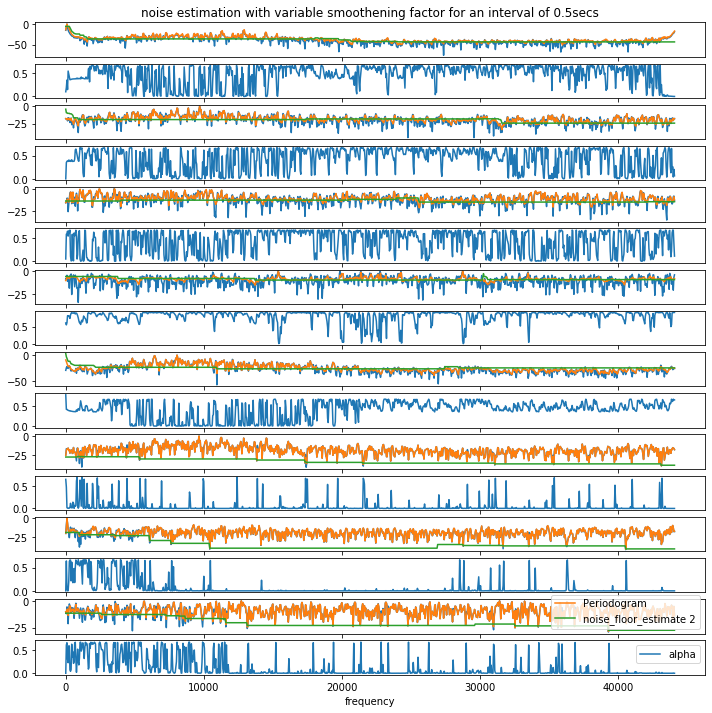

In [177]:
fig, ax = plt.subplots(niteration*2, 1, figsize=(12,12))
ax[0].set_title("noise estimation with variable smoothening factor for an interval of 0.5secs")
for i in range(niteration):
    ax[2*i].plot(f, 20*np.log10(abs(F_slide_fft[i])/max(abs(F_slide_fft[i]))))
    ax[2*i].plot(f, 10*np.log10(periodogram[i]/max(periodogram[i])), label="Periodogram")
    ax[2*i].plot(f, noise_floor_est[i], label="noise_floor_estimate 4")
    ax[2*i + 1].plot(f, valpha[i], label="alpha")
ax[niteration*2-1].set_xlabel("frequency")
ax[niteration*2-1].legend()
ax[niteration*2-2].legend()

# Final picture of the noise floor estimator

Text(0.5, 0, 'frequency')

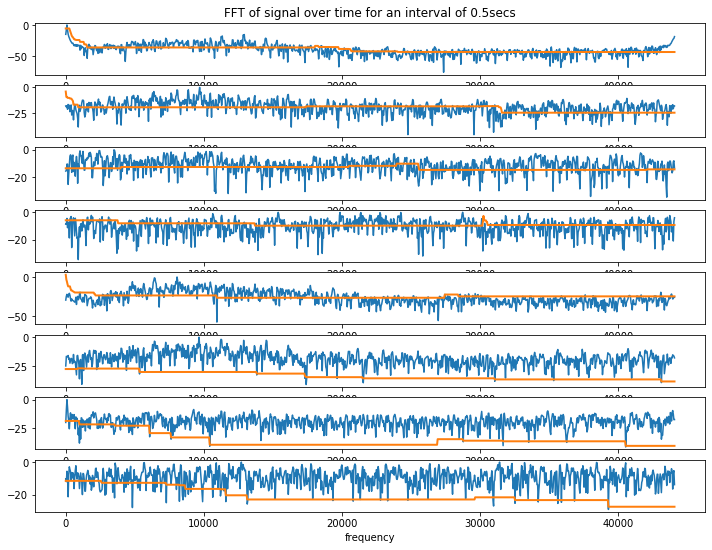

In [179]:
fig, ax = plt.subplots(niteration, 1, figsize=(12,9))
ax[0].set_title("FFT of signal over time for an interval of 0.5secs")
for i in range(niteration):
    ax[i].plot(f, 20*np.log10(abs(F_slide_fft[i])/max(abs(F_slide_fft[i]))))
    ax[i].plot(f, noise_floor_est[i], label="Minimum statistics noise floor estimator", linewidth="2")
ax[niteration-1].set_xlabel("frequency")